In [129]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [130]:
data_dir = r'D:\Code\py_code\Pattern-Recognition\Better-Sirekap\data'
img_list = os.listdir(data_dir)
img_files = [os.path.join(data_dir, img) for img in img_list]

In [131]:
def preprocess_and_crop_image(image_path, target_size=(48, 48)):
    image = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)
        cropped = gray[y:y+h, x:x+w]
        resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
        return resized
    
    resized = cv2.resize(binary, target_size, interpolation=cv2.INTER_AREA)
    return resized

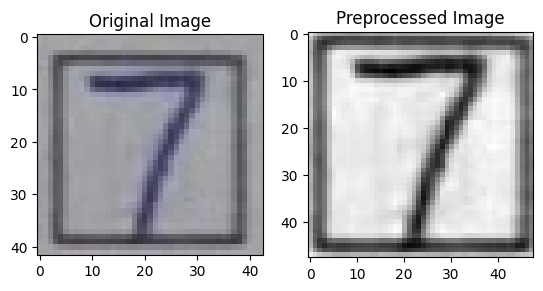

In [132]:
index = 6000
original = cv2.imread(img_files[index])
preprocessed_images = preprocess_and_crop_image(img_files[index])
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original Image')
ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax[1].set_title('Preprocessed Image')
ax[1].imshow(preprocessed_images, cmap='gray')

In [133]:
from skimage.feature import hog

def extract_hog_features(image):
    if len(image.shape) == 3:
        image = color.rgb2gray(image)  # Convert to grayscale if the image is RGB
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)
    return features

def extract_zoning_features(image, zones=(4, 4)):
    h, w = image.shape
    zh, zw = h // zones[0], w // zones[1]
    features = []
    for i in range(zones[0]):
        for j in range(zones[1]):
            zone = image[i * zh:(i + 1) * zh, j * zw:(j + 1) * zw]
            features.append(np.mean(zone))
    return np.array(features)

def extract_moment_features(image):
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments).flatten()
    return hu_moments

def extract_combined_features(image):
    binary_image = preprocess_and_crop_image(image)
    hog_features = extract_hog_features(binary_image)
    zoning_features = extract_zoning_features(binary_image)
    moment_features = extract_moment_features(binary_image)
    return np.concatenate([hog_features, zoning_features, moment_features])

In [134]:
data = img_files
labels = [int(img[0]) for img in img_list]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [135]:
len(X_train), len(X_test)

(6034, 1509)

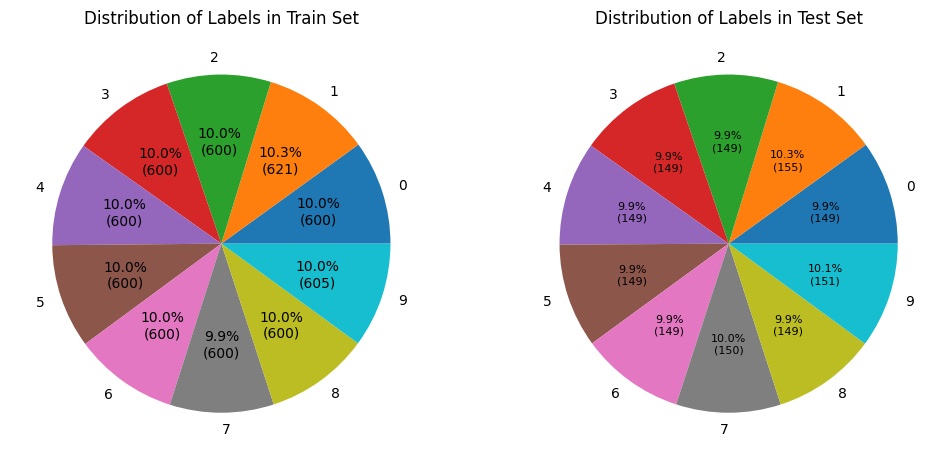

In [136]:
train_label_counts = [0] * 10
for label in y_train:
    train_label_counts[label] += 1

test_label_counts = [0] * 10
for label in y_test:
    test_label_counts[label] += 1

def func(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return f"{pct:.1f}%\n({absolute})"

labels = [str(i) for i in range(10)]
x = range(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

wedges, texts, autotexts = ax1.pie(train_label_counts, labels=labels, autopct=lambda pct: func(pct, train_label_counts))
ax1.set_title('Distribution of Labels in Train Set')

wedges, texts, autotexts = ax2.pie(test_label_counts, labels=labels, autopct=lambda pct: func(pct, test_label_counts))
ax2.set_title('Distribution of Labels in Test Set')

for text in autotexts:
    text.set_fontsize(8)

plt.show()

In [137]:
feature_extraction_combinations = [
    ("HOG + Zoning + Moment Invariants", lambda img: extract_combined_features(preprocess_and_crop_image(img))),
    ("HOG", lambda img: extract_hog_features(preprocess_and_crop_image(img))),
    ("Zoning", lambda img: extract_zoning_features(preprocess_and_crop_image(img))),
    ("Moment Invariants", lambda img: extract_moment_features(preprocess_and_crop_image(img))),
    ("HOG + Zoning", lambda img: np.concatenate([extract_hog_features(preprocess_and_crop_image(img)), extract_zoning_features(preprocess_and_crop_image(img))])),
    ("HOG + Moment Invariants", lambda img: np.concatenate([extract_hog_features(preprocess_and_crop_image(img)), extract_moment_features(preprocess_and_crop_image(img))])),
    ("Zoning + Moment Invariants", lambda img: np.concatenate([extract_zoning_features(preprocess_and_crop_image(img)), extract_moment_features(preprocess_and_crop_image(img))])),
]


In [138]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Define the SVM model
svm = SVC(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=2, cv=5)

In [139]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(rf, param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

In [140]:
# Classifier Configurations
classifiers = [
    ("SVM", SVC(kernel='linear', random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
]

In [141]:
# # Experiment Loop
# results = []

# for feature_name, feature_func in (feature_extraction_combinations):
#     X_train_features = np.array([feature_func(img) for img in X_train])
#     X_test_features = np.array([feature_func(img) for img in X_test])

#     # Scale the features
#     scaler = StandardScaler()
#     X_train_features = scaler.fit_transform(X_train_features)
#     X_test_features = scaler.transform(X_test_features)

#     for clf_name, clf in (classifiers):
#         if clf_name == "Random Forest":
#             # Perform Randomized Search for Random Forest
#             random_search.fit(X_train_features, y_train)
#             best_clf = random_search.best_estimator_
#             y_pred = best_clf.predict(X_test_features)
#         else:
#             # Perform Grid Search for SVM
#             grid_search.fit(X_train_features, y_train)
#             best_clf = grid_search.best_estimator_
#             y_pred = best_clf.predict(X_test_features)
        
#         accuracy = accuracy_score(y_test, y_pred)
#         results.append((feature_name, clf_name, accuracy))
#         print(f"Feature: {feature_name}, Classifier: {clf_name}, Accuracy: {accuracy * 100:.2f}%")

In [142]:
X_train

['D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\4_DataSet6_270.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\6_DataSet6_005.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\1_DataSet6_417.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\7_DataSet6_067.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\3_DataSet6_710.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\6_DataSet6_450.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\8_DataSet6_567.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\4_DataSet6_583.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\2_DataSet6_109.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\5_DataSet6_081.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\3_DataSet6_037.jpg',
 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\9

In [143]:
# Experiment Loop
results = []

for feature_name, feature_func in feature_extraction_combinations:
    print(X_train)
    X_train_features = np.array([feature_func(img) for img in X_train])
    X_test_features = np.array([feature_func(img) for img in X_test])

    # Scale the features
    scaler = StandardScaler()
    X_train_features = scaler.fit_transform(X_train_features)
    X_test_features = scaler.transform(X_test_features)

    for clf_name, clf in classifiers:
        clf.fit(X_train_features, y_train)
        y_pred = clf.predict(X_test_features)
        
        accuracy = accuracy_score(y_test, y_pred)
        results.append((feature_name, clf_name, accuracy))
        print(f"Feature: {feature_name}, Classifier: {clf_name}, Accuracy: {accuracy * 100:.2f}%")

['D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\4_DataSet6_270.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\6_DataSet6_005.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\1_DataSet6_417.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\7_DataSet6_067.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\3_DataSet6_710.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\6_DataSet6_450.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\8_DataSet6_567.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\4_DataSet6_583.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\2_DataSet6_109.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\5_DataSet6_081.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\3_DataSet6_037.jpg', 'D:\\Code\\py_code\\Pattern-Recognition\\Better-Sirekap\\data\\9_DataSet6_1

TypeError: Can't convert object to 'str' for 'filename'

In [163]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from skimage.feature import hog
import pandas as pd

# Directory containing the image data
data_dir = r'D:\Code\py_code\Pattern-Recognition\Better-Sirekap\data'
img_list = os.listdir(data_dir)
img_files = [os.path.join(data_dir, img) for img in img_list]

# Preprocess and crop the image to the target size
def preprocess_and_crop_image(image_path, target_size=(48, 48)):
    image = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)
        cropped = gray[y:y+h, x:x+w]
        resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
        return resized
    
    resized = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)
    return resized

# Extract HOG features from an image
def extract_hog_features(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)
    return features

# Extract zoning features from an image
def extract_zoning_features(image, zones=(4, 4)):
    h, w = image.shape
    zh, zw = h // zones[0], w // zones[1]
    features = []
    for i in range(zones[0]):
        for j in range(zones[1]):
            zone = image[i * zh:(i + 1) * zh, j * zw:(j + 1) * zw]
            features.append(np.mean(zone))
    return np.array(features)

# Extract PCA features from an image
def extract_pca_features(image, pca):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    flattened = image.flatten().reshape(1, -1)
    pca_features = pca.transform(flattened)
    return pca_features.flatten()

# Extract combined features (HOG, Zoning, PCA) from an image
def extract_combined_features(image_path, pca):
    image = preprocess_and_crop_image(image_path)
    hog_features = extract_hog_features(image)
    zoning_features = extract_zoning_features(image)
    pca_features = extract_pca_features(image, pca)
    return np.concatenate([hog_features, zoning_features, pca_features])

# Label extraction from image filenames
data = img_files
labels = [int(img[0]) for img in img_list]

# Different test splits
test_splits = [0.2, 0.3, 0.4]

# Feature extraction combinations
feature_extraction_combinations = [
    ("HOG", lambda img: extract_hog_features(preprocess_and_crop_image(img))),
    ("HOG + Zoning + PCA", lambda img: extract_combined_features(img, pca)),
    ("Zoning", lambda img: extract_zoning_features(preprocess_and_crop_image(img))),
    ("PCA", lambda img: extract_pca_features(preprocess_and_crop_image(img), pca)),
    ("HOG + Zoning", lambda img: np.concatenate([extract_hog_features(preprocess_and_crop_image(img)), extract_zoning_features(preprocess_and_crop_image(img))])),
    ("HOG + PCA", lambda img: np.concatenate([extract_hog_features(preprocess_and_crop_image(img)), extract_pca_features(preprocess_and_crop_image(img), pca)])),
    ("Zoning + PCA", lambda img: np.concatenate([extract_zoning_features(preprocess_and_crop_image(img)), extract_pca_features(preprocess_and_crop_image(img), pca)])),
    ("Raw Pixels", lambda img: preprocess_and_crop_image(img).flatten()),
]

# Classifier configurations
classifiers = [
    ("SVM", SVC(kernel='linear', random_state=42, gamma=0.001, C=10, probability=True)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
]

# Experiment loop
results = []

for test_split in test_splits:
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_split, random_state=42, stratify=labels)
    
    # Prepare PCA on training data
    all_images = [preprocess_and_crop_image(img) for img in X_train]
    flattened_images = [img.flatten() for img in all_images]
    pca = PCA(n_components=min(50, len(flattened_images[0])), random_state=42)
    pca.fit(flattened_images)

    for feature_name, feature_func in feature_extraction_combinations:
        X_train_features = np.array([feature_func(img) for img in X_train])
        X_test_features = np.array([feature_func(img) for img in X_test])

        # Scale the features
        scaler = StandardScaler()
        X_train_features = scaler.fit_transform(X_train_features)
        X_test_features = scaler.transform(X_test_features)

        for clf_name, clf in classifiers:
            clf.fit(X_train_features, y_train)
            y_pred = clf.predict(X_test_features)
            
            accuracy = accuracy_score(y_test, y_pred)
            results.append((feature_name, clf_name, test_split, round(accuracy*100, 2)))
            print(f"Test Split: {test_split}, Feature: {feature_name}, Classifier: {clf_name}, Accuracy: {accuracy * 100:.2f}%")

Test Split: 0.2, Feature: HOG, Classifier: SVM, Accuracy: 98.34%


KeyboardInterrupt: 

In [ ]:
# Display the results in a DataFrame
df_results = pd.DataFrame(results, columns=['Feature Extraction', 'Classifier', 'Test Split', 'Accuracy'])
df_pivot = df_results.pivot_table(index=['Feature Extraction', 'Classifier'], columns='Test Split', values='Accuracy').reset_index()
df_pivot.columns.name = None
df_pivot

,Feature Extraction,Classifier,0.2,0.3,0.4
0,HOG,Random Forest,0.970179,0.967300,0.964877
1,HOG,SVM,0.983433,0.982766,0.979125
2,HOG + PCA,Random Forest,0.969516,0.968184,0.964215
3,HOG + PCA,SVM,0.982770,0.982324,0.979788
4,HOG + Zoning,Random Forest,0.966865,0.965974,0.964877
5,HOG + Zoning,SVM,0.982107,0.982324,0.979457
6,HOG + Zoning + PCA,Random Forest,0.970842,0.969510,0.964877
7,HOG + Zoning + PCA,SVM,0.982770,0.981882,0.979457
8,PCA,Random Forest,0.630219,0.563853,0.537773
9,PCA,SVM,0.605699,0.547945,0.525845


In [ ]:
# get best parameters
# print(grid_search.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
# print(random_search.best_params_)

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
